In [3]:
%%capture
%pip install transformers
%pip install pandas 
%pip install torch
%pip install tqdm

In [4]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm


/home/hussein/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
datapath = f"/content/drive/MyDrive/IMDB_dataset/data/IMDB Dataset.csv"
df = pd.read_csv(datapath)
df


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


<AxesSubplot: xlabel='sentiment'>

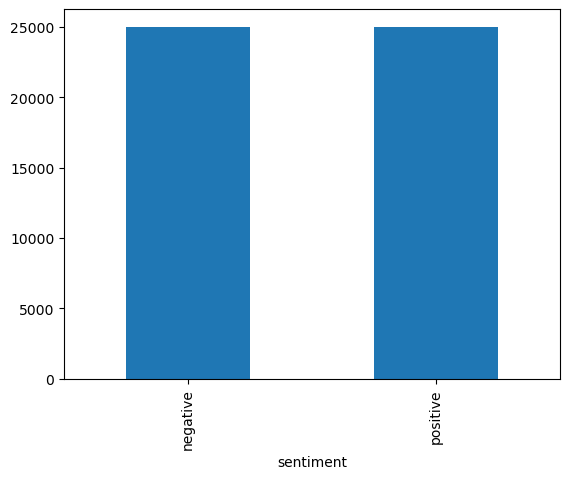

In [6]:
df.groupby(["sentiment"]).size().plot.bar()


In [7]:
g = df.groupby(["sentiment"])
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
negative, positive = g.iloc[: len(g) // 2], g[len(g) // 2 :]
negative


review sentiment
sentiment                                                                   
negative  0      A big waste of time is all you'll get out of t...  negative
          1      All movies that contain "goofy sound effects" ...  negative
          2      Anyone giving this movie a good review obvious...  negative
          3      Poor Casper Van Dien, his career has slid a lo...  negative
          4      I got a kick out of Reynolds saying to his att...  negative
...                                                            ...       ...
          24995  Genre: Cartoon short with no dialogue, African...  negative
          24996  I am almost a two decade old human who's been ...  negative
          24997  This movie was so bad and so cheap and so corn...  negative
          24998  A sexually obsessed chef leads a duplicitous l...  negative
          24999  After a few misfires, we are still waiting for...  negative

[25000 rows x 2 columns]

In [8]:
np.random.seed(112)
df_train_positive, df_val_positive, df_test_positive = np.split(
    positive.sample(frac=1, random_state=42),
    [int(0.7 * len(positive)), int(0.8 * len(positive))],
)

print(len(df_train_positive), len(df_val_positive), len(df_test_positive))


17500 2500 5000


In [9]:
np.random.seed(112)
df_train_negative, df_val_negative, df_test_negative = np.split(
    negative.sample(frac=1, random_state=42),
    [int(0.7 * len(negative)), int(0.8 * len(negative))],
)

print(len(df_train_negative), len(df_val_negative), len(df_test_negative))


17500 2500 5000


In [10]:
df_train = pd.concat([df_train_positive, df_train_negative])
df_val = pd.concat([df_val_positive, df_val_negative]).reset_index(drop=True)
df_test = pd.concat([df_test_positive, df_test_negative]).reset_index(drop=True)

print(len(df_train), len(df_val), len(df_test))
df_train


35000 5000 10000


review sentiment
sentiment                                                                   
positive  6868   This is the best movie I've ever seen! <br /><...  positive
          24016  I saw this 25 years ago on PBS. It was very di...  positive
          9668   A bright youngster interested in "serious" mus...  positive
          13640  Mike Judge's Idiocracy is an interesting film,...  positive
          14018  i really love this movie , i saw it for the fi...  positive
...                                                            ...       ...
negative  9730   Recap: Not entirely familiar with the Shakespe...  negative
          21746  I'm sorry, but this movie is just way to shall...  negative
          21454  Well, the movie was no terrible, but whomever ...  negative
          7734   One: Richard Pryor and Jackie Gleason, two gre...  negative
          885    Seeing this movie, as I just did for the first...  negative

[35000 rows x 2 columns]

In [12]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

print(len(df_train), len(df_val), len(df_test))
df_train


35000 5000 10000


,review,sentiment
0,This movie has got to be about one of the wors...,negative
1,"Being a history buff, I rented this movie beca...",negative
2,You can't really blame the movie maker for glo...,negative
3,"""The Invisible Ray"" is part science fiction an...",positive
4,I have no idea what idiots gave this movie a P...,negative
...,...,...
34995,There are no flaws in this production. Perfect...,positive
34996,Some very interesting camera work and a story ...,negative
34997,Cute Movie feel good movie I had never heard o...,positive
34998,This deserves a 12 out of 10. An absolutely re...,positive


In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {
    "negative": 0,
    "positive": 1,
}


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df["sentiment"]]
        self.texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["review"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [15]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear5 = nn.Linear(64, 1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(
            input_ids=input_id, attention_mask=mask, return_dict=False
        )
        dropout_output = self.dropout(pooled_output)
        linear1_output = torch.relu(self.linear1(dropout_output))
        linear2_output = torch.relu(self.linear2(linear1_output))
        linear3_output = torch.relu(self.linear3(linear2_output))
        linear4_output = torch.relu(self.linear4(linear3_output))
        final_layer = torch.sigmoid(self.linear5(linear4_output))

        return final_layer


In [16]:
def train(model, train_data, val_data, learning_rate, epochs,batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            
            print(output, type(output))
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            # output = output.ge(.5).view(-1)

            # TODO: Modify accuracy
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                print(output, type(output))

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        )


In [17]:
def evaluate(model, test_data, batch_size):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input["attention_mask"].to(device)
            input_id = test_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            print(output, type(output))

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f"Test Accuracy: {total_acc_test / len(test_data): .3f}")


In [18]:
EPOCHS = 50
model = BertClassifier()
LR = 1e-6
batch_size = 128

train(model, df_train, df_val, LR, EPOCHS, batch_size)


Downloading: 100%|██████████| 436M/436M [02:06<00:00, 3.45MB/s] 
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/274 [00:00<?, ?it/s]

: 

: 

In [ ]:
batch_size=128
evaluate(model, df_test, batch_size)